In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [10]:
salary = pd.read_csv("salary.csv")
salary.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,Salary_50K
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,no
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,no
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,no
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,no
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,no


#### Remove empty strings and missing values

In [11]:
salary = salary.replace(' ',np.nan)
salary.isna().sum()

age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
hours-per-week       0
native-country     583
Salary_50K           0
dtype: int64

In [12]:
# remove nas
salary = salary.dropna()

In [13]:
#Removing outliers
salary['age'] = salary['age'].clip(lower=salary['age'].quantile(0.05),upper=salary['age'].quantile(0.95))
salary['education-num'] = salary['education-num'].clip(lower=salary['education-num'].quantile(0.05),upper=salary['education-num'].quantile(0.95))

In [21]:
salary.describe()

 no    22654
yes     7508
Name: Salary_50K, dtype: int64

### Exploratory Data Analysis

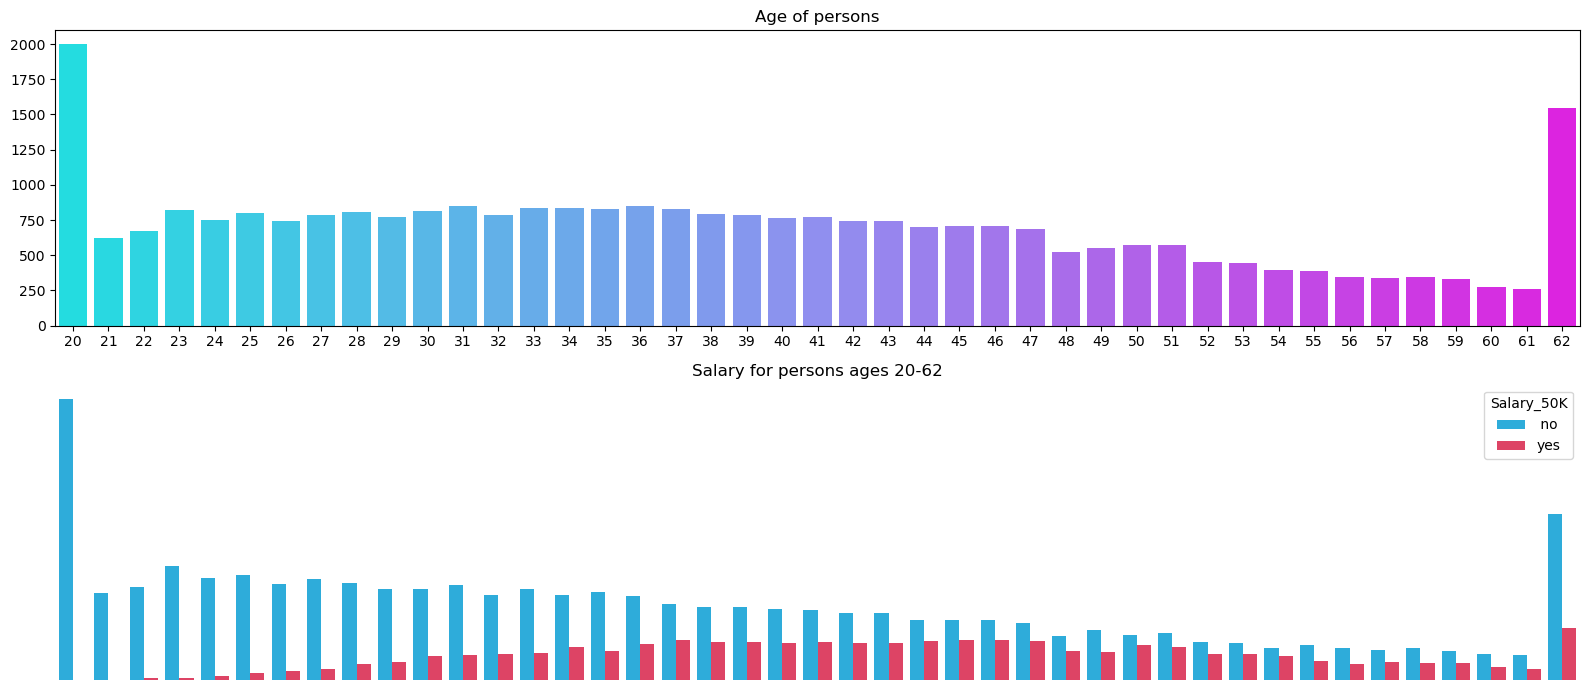

In [20]:
fig, axes = plt.subplots(2,1,figsize=(16,7))
sns.countplot(x=salary['age'], ax=axes[0], palette='cool')
axes[0].set_title('Age of persons')
sns.countplot(x=salary['age'], hue=salary['Salary_50K'],ax=axes[1], palette=['#11B9F7','#F72A57'])
axes[1].set_title('Salary for persons ages 20-62')
axes[1].axis('off')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
plt.tight_layout()
plt.show()

##### As the age increases, so does the salary of the employee. We don't see employees earning more than 50K in their early 20s 

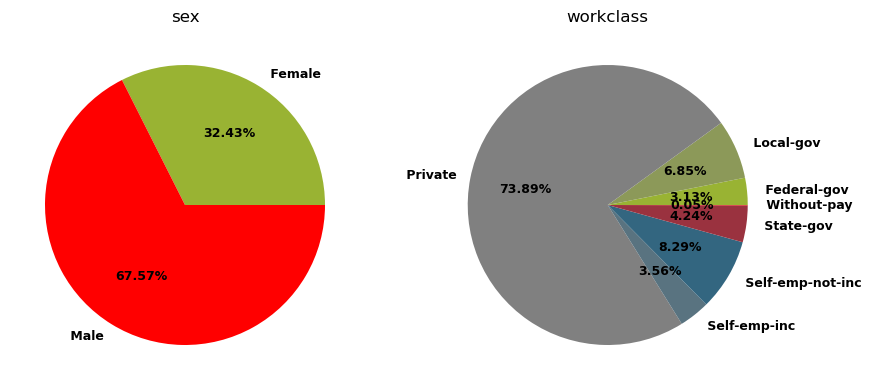

In [8]:
import matplotlib.colors as mcolors

colors = [(0.6, 0.7, 0.2), (0.5, 0.5, 0.5), (0.2, 0.4, 0.5), (1, 0, 0)]
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

cols = ['sex','workclass']
plt.figure(figsize=(10,10))
for i, col in enumerate(cols):
    ax = plt.subplot(2,2, i + 1)
    salary.groupby([col])['Salary_50K'].count().plot.pie(autopct='%.2f%%', textprops={'size':9,'fontweight':'bold'},cmap=cmap)
    plt.title(col)
    plt.axis('off')
plt.show()

##### Capacity comprises of more than 30% of the workforce are Female.
##### Employees belonging to Private companies are much more than those of other workclasses 

<Figure size 1000x1000 with 0 Axes>

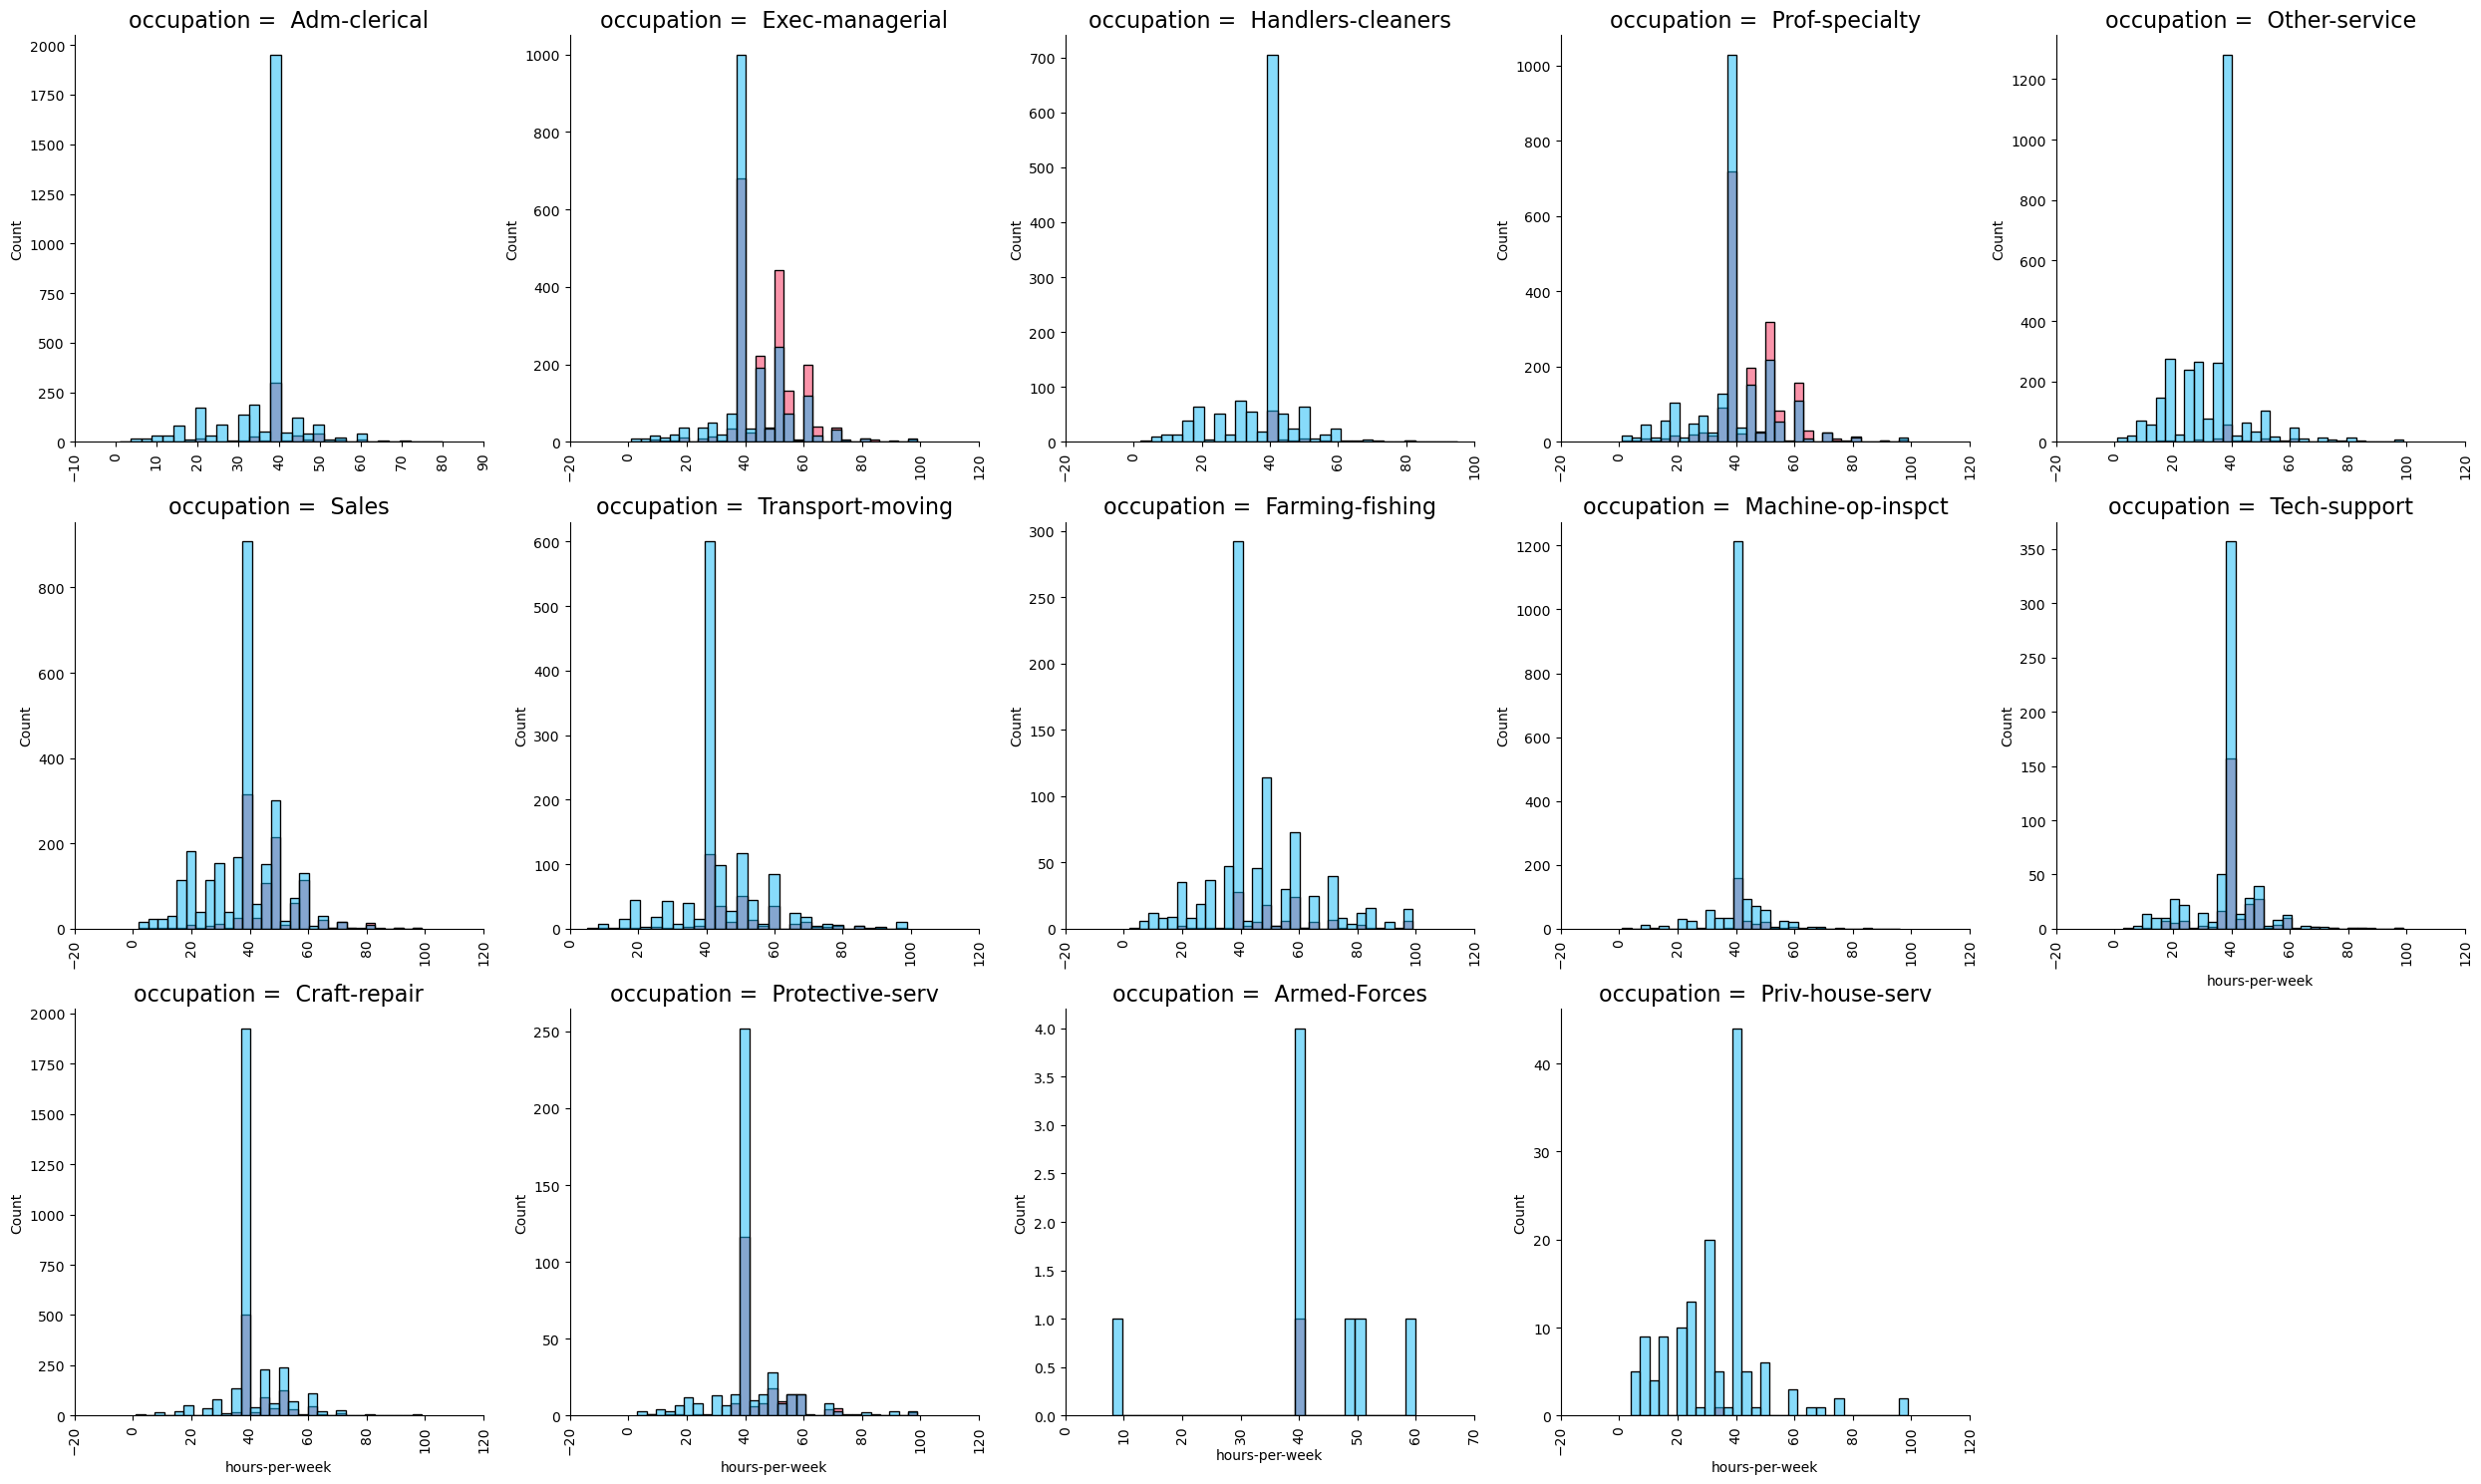

In [9]:
plt.figure(figsize=(10,10))
g = sns.FacetGrid(salary, col='occupation', col_wrap=5,height=5, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x='hours-per-week', hue='Salary_50K', palette=['#11B9F7','#F72A57'], alpha=0.5,bins=30)
g.set_titles(size=16)
g.set_xticklabels(rotation=90)
plt.tight_layout()
plt.show()

##### In most occupations, employees work 40 hours a week except Armed Forces
##### Employees working as 'Exec-managerial' or 'Prof-specialty' require more expertise and therefore earn more than others 

In [10]:
dummies = pd.get_dummies(salary.select_dtypes('object'),drop_first=True)
df_salary = salary.join(dummies)
df_salary.drop(df_salary.select_dtypes('object'),axis=1,inplace=True)
df_salary.reset_index(drop=True)

characters = "()-"
for i in characters:
    df_salary.columns = list(map(lambda x : x.replace(i,"_"),df_salary.columns))

In [11]:
x = df_salary.drop("Salary_50K_yes",axis=1)
y = df_salary["Salary_50K_yes"]

rf = RandomForestClassifier(n_estimators=10,max_depth=5).fit(x,y)
select_rf = x.loc[:,rf.feature_importances_>0.0]

vt = VarianceThreshold(threshold=0.25).fit(x)
select_vt = x.loc[:,vt.get_support()]

select_feat = select_rf if select_rf.count(axis=1).unique() <= select_vt.count(axis=1).unique() else select_vt
select_model = "RandomForestClassifier" if select_rf.count(axis=1).unique() <= select_vt.count(axis=1).unique() else "VarianceThreshold"
print("Model:",select_model,"\nNumber of features:",select_feat.count(axis=1).unique())

Model: VarianceThreshold 
Number of features: [3]


In [12]:
x_train,x_test,y_train,y_test = train_test_split(select_feat,y,test_size=0.25,random_state=42)

In [13]:
best_score = 0

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,KFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline

scalers = [StandardScaler(),MinMaxScaler()]

classifiers = [{"name":"Logistic Regression","model":LogisticRegression()},
              {"name":"Multi-layer Perceptron","model":MLPClassifier(hidden_layer_sizes=(10,5),learning_rate_init=0.01)},
              {"name":"Random Forest","model":RandomForestClassifier(n_estimators=10,max_depth=5)},
              {"name":"ADA Boost","model":AdaBoostClassifier(learning_rate=0.1)}]

for scaler in scalers:
    for i in range(len(classifiers)):
        kfolds = KFold(n_splits=5)
        cv_scores = cross_val_score(make_pipeline(scaler,classifiers[i]["model"]),x_train,y_train,cv=kfolds)
        mean_score = np.mean(cv_scores)
        if mean_score > best_score:
            best_score = mean_score
            model_name = classifiers[i]["name"]
            best_model = classifiers[i]["model"].fit(x_train,y_train)

print("Best Model:",model_name,"\nBest Score:",best_score)

Best Model: Multi-layer Perceptron 
Best Score: 0.7927149102881623


              precision    recall  f1-score   support

           0       0.89      0.84      0.86      6031
           1       0.48      0.60      0.53      1510

    accuracy                           0.79      7541
   macro avg       0.69      0.72      0.70      7541
weighted avg       0.81      0.79      0.80      7541



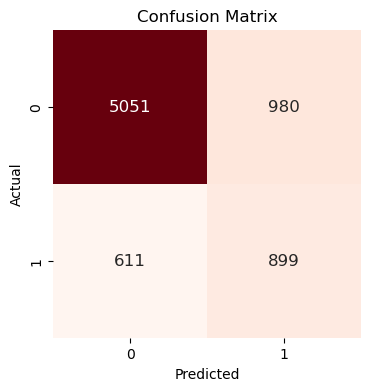

In [14]:
from sklearn.metrics import classification_report,confusion_matrix
preds = best_model.predict(x_test)

data = confusion_matrix(preds,y_test)
cm = pd.DataFrame(data,columns=np.unique(y_test),index=np.unique(y_test))
cm.index.name = "Actual"
cm.columns.name = "Predicted"
plt.figure(figsize=(4,4))
plt.title("Confusion Matrix")
sns.heatmap(cm,cmap="Reds",annot=True,square=True,fmt='d',annot_kws={"size":"12"},vmax=5000,cbar=False,)

print(classification_report(preds,y_test))

#### We can predict whether an employee will have a salary > 50K by the recall. If precision determines the accuracy of our model, then recall evaluates the model's ability to serve the purpose intended. It appears our model can correctly predict the outcomes up to 53%. 

#### Type 1 errors are observed as assuming Salary_50K is "Yes" when actually that is false. Type 2 errors are observed as assuming Salary_50K is "No" when actually that is not true

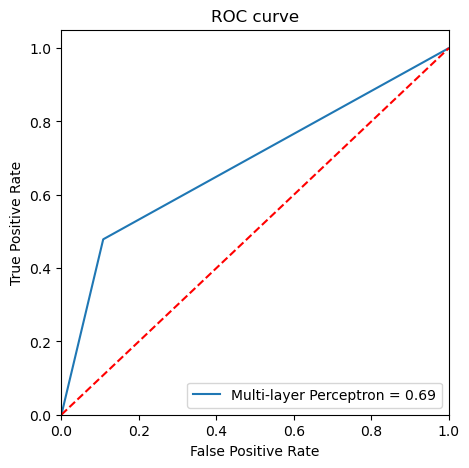

In [15]:
from sklearn.metrics import roc_auc_score,roc_curve

roc_auc = roc_auc_score(y_test,preds)
tpr, fpr, threshold = roc_curve(y_test,preds)
plt.figure(figsize=(5,5))
plt.title("ROC curve")
plt.plot(tpr,fpr,label=model_name+" = %.2f"%(roc_auc))
plt.plot([0,1],[0,1],'r--')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
#plt.savefig('figpath.svg')

#### A ROC curve of 0.69 is moderate level of accuracy in distinguishing between positive and negative classes. Classifiers that give curves closer to the top-left corner indicate a better performance of the model.